In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define the path to the zip file and the name of the CSV file within the zip
zip_file_path = 'usa-real-estate-dataset.zip'
csv_file_name = 'realtor-data.zip.csv'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Read the CSV file into a pandas DataFrame
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)

def clean_data(df):
    """
    Clean the input DataFrame by dropping rows with NaNs in specified columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be cleaned.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    # Drop rows with NaNs in 'bed', 'bath', 'acre_lot', 'house_size', and 'price' columns
    df_cleaned = df.dropna(subset=['bed', 'bath', 'acre_lot', 'house_size', 'price'])
    return df_cleaned

df_2 = clean_data(df)

#seed
seed = 481
np.random.seed(seed)

# Sample 10% of the rows since dataset is big
# df_2 = df_2.sample(frac=0.1, random_state=1)

In [2]:
def find_houses(data, budget=None, min_bedrooms=0, min_bathrooms=0, preferred_state=None, 
                preferred_city=None, min_lot_size=0, max_lot_size=None):
    """
    Filter houses based on the given criteria.

    Parameters:
    data (pd.DataFrame): The DataFrame containing house listings.
    budget (float, optional): Maximum price of the house. Defaults to None.
    min_bedrooms (int, optional): Minimum number of bedrooms required. Defaults to 0.
    min_bathrooms (int, optional): Minimum number of bathrooms required. Defaults to 0.
    preferred_state (str, optional): Preferred state for the house location. Defaults to None.
    preferred_city (str, optional): Preferred city for the house location. Defaults to None.
    min_lot_size (float, optional): Minimum lot size in acres. Defaults to 0.
    max_lot_size (float, optional): Maximum lot size in acres. Defaults to None.

    Returns:
    pd.DataFrame: A DataFrame containing houses that meet the specified criteria.
    """
    # Filter based on budget if provided
    if budget is not None:
        filtered_data = data[(data['price'] <= budget) & (data['status'] == 'for_sale')]
    else:
        filtered_data = data[data['status'] == 'for_sale']

    # Filter based on number of bedrooms
    if min_bedrooms > 0:
        filtered_data = filtered_data[filtered_data['bed'] >= min_bedrooms]

    # Filter based on number of bathrooms
    if min_bathrooms > 0:
        filtered_data = filtered_data[filtered_data['bath'] >= min_bathrooms]

    # Filter based on preferred state
    if preferred_state:
        filtered_data = filtered_data[filtered_data['state'].str.lower() == preferred_state.lower()]

    # Filter based on preferred city
    if preferred_city:
        filtered_data = filtered_data[filtered_data['city'].str.lower() == preferred_city.lower()]

    # Filter based on lot size
    if min_lot_size > 0:
        filtered_data = filtered_data[filtered_data['acre_lot'] >= min_lot_size]
        
    if max_lot_size is not None:
        filtered_data = filtered_data[filtered_data['acre_lot'] <= max_lot_size]

    return filtered_data

In [3]:
# Example 1
budget = 1000000
min_bedrooms = 3
min_bathrooms = 2
preferred_state = 'Washington'
preferred_city = 'Seattle'
min_lot_size = 0.1
max_lot_size = 5.0

results = find_houses(df_2, budget, min_bedrooms, min_bathrooms, preferred_state, preferred_city)
print(results.head())

         brokered_by    status     price  bed  bath  acre_lot     street  \
1391867     108308.0  for_sale  948000.0  3.0   3.0      0.03   797801.0   
1391902     110027.0  for_sale  900000.0  3.0   3.0      0.07  1806629.0   
1391906     108301.0  for_sale  915000.0  4.0   2.0      0.12  1789379.0   
1391907      52723.0  for_sale  869950.0  3.0   3.0      0.03  1077515.0   
1391909      52875.0  for_sale  849950.0  3.0   2.0      0.08  1583482.0   

            city       state  zip_code  house_size prev_sold_date  
1391867  Seattle  Washington   98102.0      1470.0     2013-10-10  
1391902  Seattle  Washington   98103.0      2460.0     2003-05-28  
1391906  Seattle  Washington   98103.0      1730.0     2015-06-26  
1391907  Seattle  Washington   98103.0      1607.0     2010-06-15  
1391909  Seattle  Washington   98103.0      1560.0     1981-07-06  


In [4]:
# Example 2
min_bedrooms = 1
min_lot_size = 0.2
preferred_state = 'Colorado'

results = find_houses(df_2, min_bedrooms = min_bedrooms, min_lot_size = 0.2, 
                      preferred_state = preferred_state)
print(results.head())

        brokered_by    status     price  bed  bath  acre_lot     street  \
946862      86788.0  for_sale  129500.0  2.0   1.0      0.24  1103130.0   
946866      79200.0  for_sale  399000.0  3.0   3.0      0.26   951198.0   
946867      31049.0  for_sale  225000.0  2.0   2.0      0.26  1289928.0   
946869      91017.0  for_sale  315000.0  4.0   2.0      0.32  1389034.0   
946870      79200.0  for_sale  689000.0  4.0   3.0     17.56   359222.0   

              city     state  zip_code  house_size prev_sold_date  
946862  Burlington  Colorado   80807.0      1466.0     1990-04-04  
946866  Burlington  Colorado   80807.0      3768.0            NaN  
946867  Burlington  Colorado   80807.0      1476.0            NaN  
946869        Wray  Colorado   80758.0      1664.0     2019-05-24  
946870  Burlington  Colorado   80807.0      4446.0     2017-06-01  


In [5]:
def plot_house_frequency(df, budget=None, min_bedrooms=0, min_bathrooms=0, 
                         preferred_state=None, preferred_city=None, min_lot_size=0, max_lot_size=None):
    """
    Plot the frequency of houses that meet the specified criteria by state, city, or street.

    Parameters:
    df (pd.DataFrame): The DataFrame containing house listings.
    budget (float, optional): Maximum price of the house. Defaults to None.
    min_bedrooms (int, optional): Minimum number of bedrooms required. Defaults to 0.
    min_bathrooms (int, optional): Minimum number of bathrooms required. Defaults to 0.
    preferred_state (str, optional): Preferred state for the house location. Defaults to None.
    preferred_city (str, optional): Preferred city for the house location. Defaults to None.
    min_lot_size (float, optional): Minimum lot size in acres. Defaults to 0.
    max_lot_size (float, optional): Maximum lot size in acres. Defaults to None.

    Returns:
    None
    """
    # Call the find_houses function to filter the data
    filtered_data = find_houses(df, budget, min_bedrooms, min_bathrooms, preferred_state, 
                                preferred_city, min_lot_size, max_lot_size)

    if preferred_city:
        # Plot frequency by street if city is specified
        plot_data = filtered_data['street'].value_counts()
        title = f'House Frequency by Street in {preferred_city}'
        xlabel = 'Street'
    elif preferred_state:
        # Plot frequency by city if state is specified but city is not
        plot_data = filtered_data['city'].value_counts()
        title = f'House Frequency by City in {preferred_state}'
        xlabel = 'City'
    else:
        # Plot frequency by state if state is not specified
        plot_data = filtered_data['state'].value_counts()
        title = 'House Frequency by State'
        xlabel = 'State'

    # Plotting the data
    plt.figure(figsize=(14, 7))
    plot_data.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()


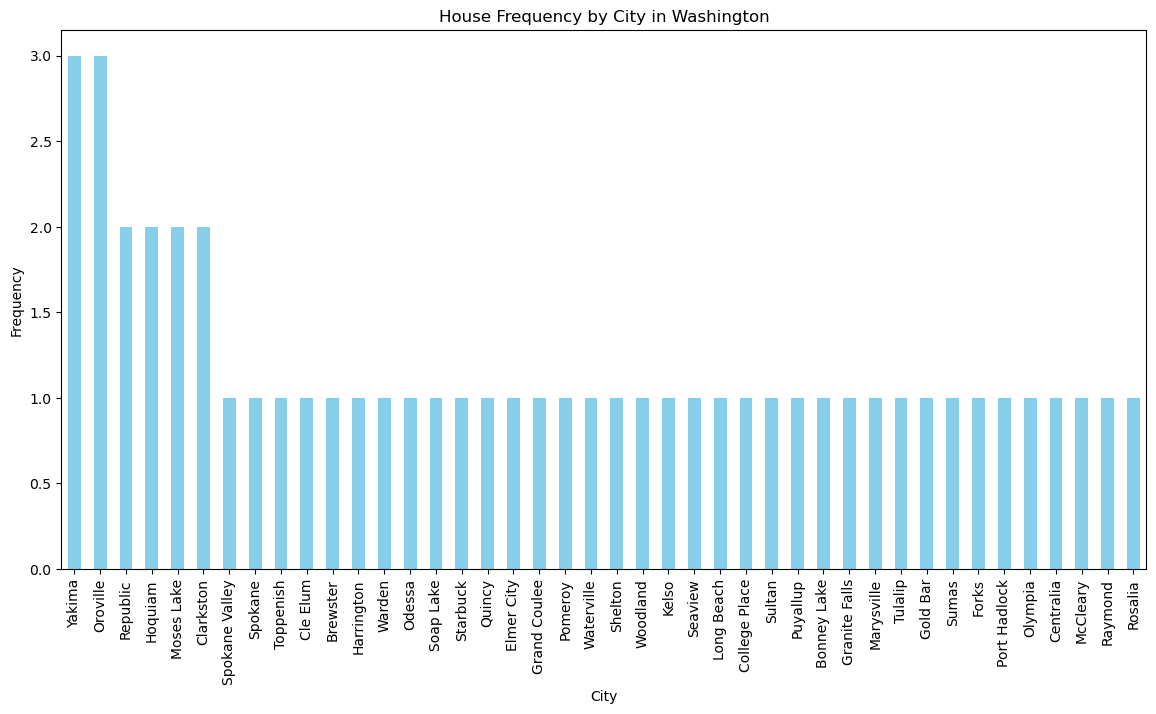

In [6]:
# Example 1
budget = 200000
min_bedrooms = 3
min_bathrooms = 2
preferred_state = 'Washington'
preferred_city = None
min_lot_size = 0.1
max_lot_size = 1.0

plot_house_frequency(df_2, budget, min_bedrooms, min_bathrooms, preferred_state, preferred_city, min_lot_size, max_lot_size)


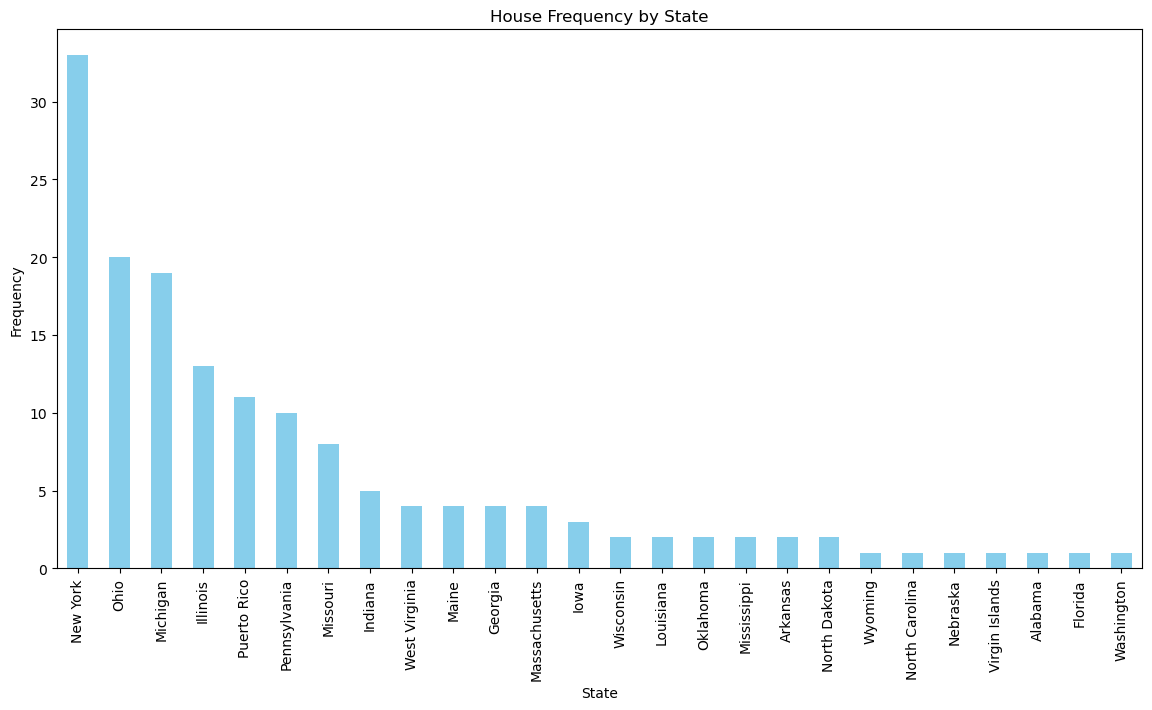

In [7]:
# Example 2
budget = 100000
min_bedrooms = 6
min_bathrooms = 4

plot_house_frequency(df_2, budget, min_bedrooms, min_bathrooms)


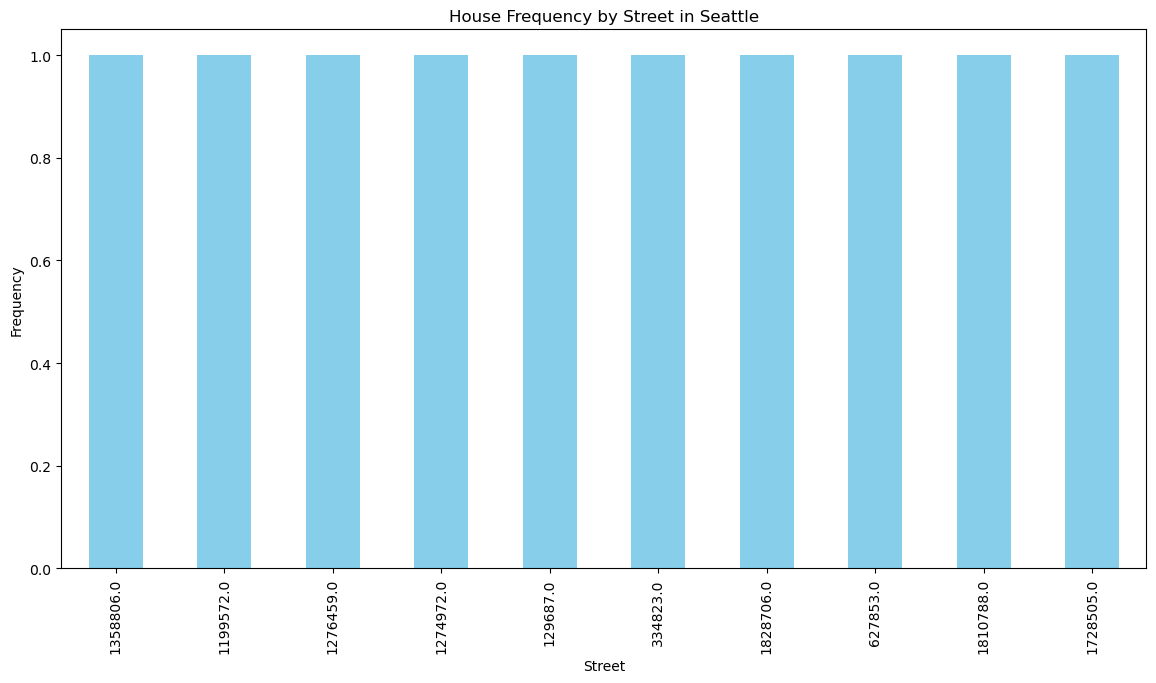

In [8]:
# Example 3
min_bedrooms = 8
min_bathrooms = 4
city = 'Seattle'
plot_house_frequency(df_2, min_bedrooms = min_bedrooms, min_bathrooms = min_bathrooms, preferred_city = city)

In [9]:
def drop_small_classes(df, target_column, min_samples=10):
    """
    Drop classes with fewer than the specified minimum number of samples.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_column (str): The target column name.
    min_samples (int): The minimum number of samples required for each class.

    Returns:
    pd.DataFrame: The DataFrame with small classes removed.
    """
    value_counts = df[target_column].value_counts()
    to_keep = value_counts[value_counts >= min_samples].index
    return df[df[target_column].isin(to_keep)]

# Define the feature columns and the target column
feature_columns = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
target_column = 'city'

# Filter the data for the state of Washington
df_washington = df_2[df_2['state'].str.lower() == 'washington']

# Drop rows with missing target values
df_washington = df_washington.dropna(subset=[target_column])

# Drop classes with fewer than the threshold number of samples
df_washington = drop_small_classes(df_washington, target_column, min_samples=5)

In [10]:
# Prepare the feature matrix (X) and the target vector (y)
X = df_washington[feature_columns]
y = df_washington[target_column]

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Create a pipeline with a StandardScaler and Logistic Regression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.16
Classification Report:
                    precision    recall  f1-score   support

         Aberdeen       0.00      0.00      0.00        46
             Addy       0.00      0.00      0.00         3
   Airway Heights       0.00      0.00      0.00        26
           Algona       0.00      0.00      0.00         6
            Allyn       0.00      0.00      0.00        12
            Amboy       0.00      0.00      0.00         4
        Anacortes       0.00      0.00      0.00        47
  Anderson Island       0.00      0.00      0.00         5
            Ariel       0.00      0.00      0.00         2
        Arlington       0.06      0.01      0.02        69
          Ashford       0.00      0.00      0.00         3
           Asotin       0.00      0.00      0.00         4
           Auburn       0.02      0.00      0.01       205
Bainbridge Island       0.00      0.00      0.00        48
    Battle Ground       0.00      0.00      0.00        94
          Belfai

In [11]:
# Function to predict city
def predict_city(price, bed, bath, acre_lot, house_size):
    """
    Predict the city in Washington based on the input house features.

    Parameters:
    price (float): The price of the house.
    bed (int): The number of bedrooms.
    bath (int): The number of bathrooms.
    acre_lot (float): The lot size in acres.
    house_size (float): The size of the house in square feet.

    Returns:
    str: The predicted city.
    """
    # Create a DataFrame from the input
    input_data = pd.DataFrame([[price, bed, bath, acre_lot, house_size]], columns=feature_columns)
    
    # Use the pipeline to scale the input and make a prediction
    predicted_city = pipeline.predict(input_data)[0]
    
    return predicted_city

In [12]:
# Example
price = 500000
bed = 3
bath = 2
acre_lot = 0.5
house_size = 2000

predicted_city = predict_city(price, bed, bath, acre_lot, house_size)
print(f"The predicted city for the given house features is: {predicted_city}")

The predicted city for the given house features is: Spokane
